# Pubmed Paper Classification - Curate Data

## Import relevant libraries

In [1]:
import os
import time
import xml.etree.ElementTree as ET

import pandas as pd
from tqdm import tqdm as _tqdm
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup

In [2]:
input_dt = '8.26.21'
input_fn = '../input/pubmed-%s.xlsx' % input_dt
efetch_fn = '../input/efetch-%s.xml' % input_dt
failed_fn = '../input/failed-%s.pickle' % input_dt
data_fn = '../input/abstracts-%s.pickle' % input_dt

## Preprocess article list and labels

In [3]:
pm = pd.read_excel(input_fn)[['PMID','Title','Category']]
orig = pm.copy()
pm.drop(['Title'], axis=1, inplace=True)
pm

,PMID,Category
0,25553339,1
1,26663098,1
2,27014455,1
3,27088280,1
4,27112773,1
...,...,...
13997,34231533,10
13998,34233515,10
13999,34234854,10
14000,34235035,10


In [4]:
pm.Category.unique()

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10])

In [5]:
pm.drop_duplicates(subset='PMID', inplace=True)
pm_filtered = pm[pd.to_numeric(pm.Category, errors='coerce').notnull()]
pm_filtered = pm_filtered[(pm_filtered.Category >= 1) & (pm_filtered.Category <= 10)]
pm_filtered

,PMID,Category
0,25553339,1
1,26663098,1
2,27014455,1
3,27088280,1
4,27112773,1
...,...,...
13996,34231311,10
13997,34231533,10
13998,34233515,10
13999,34234854,10


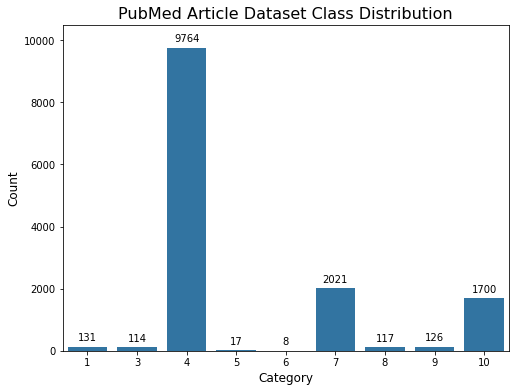

In [6]:
counts = pm_filtered.Category.value_counts().sort_index()

plt.figure(figsize=(8, 6))
splot=sns.barplot(x=counts.index,y=counts, color='tab:blue')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylim(0,10500)
plt.title('PubMed Article Dataset Class Distribution', size=16)
plt.xlabel('Category', size=12)
plt.ylabel('Count', size=12);

## Fetch abstracts (don't need to run unless new input)

In [7]:
# if os.path.isfile(efetch_fn):
#     os.remove(efetch_fn)

# tmp = ','.join([str(i) for i in pm_filtered.PMID.tolist()])
# !efetch -db pubmed -id {tmp} -format xml > {efetch_fn}

## Parse efetch output

In [8]:
with open(efetch_fn) as f:
    soup = BeautifulSoup(f, 'lxml-xml')

In [9]:
abstracts = {}
failed = []

for node in soup('PubmedArticle'):
    pmid = int(node.find('PMID').text)
    if node('AbstractText'):
        abstracts[pmid] = node.find('AbstractText').text
    else:
        failed.append(pmid)

print(len(failed), 'response from efetch but no abstract')

for pmid in pm_filtered.PMID.tolist():
    if pmid not in abstracts and pmid not in failed:
        failed.append(pmid)

print(len(failed), 'failed total')

284 response from efetch but no abstract
291 failed total


In [10]:
pm_abstracts = pd.DataFrame(list(abstracts.items()), columns=['PMID', 'Abstract'])
pm_abstracts

,PMID,Abstract
0,25553339,Cerebellar ataxia is a progressive neuro-degen...
1,26663098,Facial analysis systems are becoming available...
2,27014455,Patients with Williams-Beuren Syndrome can be ...
3,27112773,The genetic basis of numerous intellectual dis...
4,27356087,We report four individuals from two unrelated ...
...,...,...
13702,34231311,Deep learning (DL) has shown rapid advancement...
13703,34231533,Systemic retinal biomarkers are biomarkers ide...
13704,34233515,"In the last few years, artificial intelligence..."
13705,34234854,Despite the significant progress in diagnosis ...


## Drop invalid abstracts

In [11]:
drop = ['A correction to this article has been published and is linked from the HTML and PDF versions of this paper. The error has not been fixed in the paper.',
        'An amendment to this paper has been published and can be accessed via a link at the top of the paper.']
print(pm_abstracts[pm_abstracts.Abstract.isin(drop)].shape)
pm_abstracts.drop(pm_abstracts[pm_abstracts.Abstract.isin(drop)].index, inplace=True)
pm_abstracts.shape

(6, 2)


(13701, 2)

## Save files

In [12]:
tmp = pm_abstracts.PMID.tolist()
failed = []
for n, row in orig.iterrows():
    if row.PMID not in tmp:
        failed.append(row)

failed = pd.DataFrame(failed)

if os.path.isfile(failed_fn):
    os.remove(failed_fn)

failed.to_pickle(failed_fn)
failed

,PMID,Title,Category
3,27088280,Microtia in Cornelia de Lange syndrome: a case...,1
67,32529320,Further delineation of the neurodevelopmental ...,1
130,Not in Pubmed,DeepGestalt analysis of the SETD5-associated i...,1
131,Not in Pubmed,A case of Noonan syndrome diagnosed using the ...,1
132,Not in Pubmed,Integrated facial analysis and targeted sequen...,1
...,...,...,...
13952,34126753,Promise and Frustration: Machine Learning in C...,10
13959,34138986,Putting the Pieces Together: Deep Learning for...,10
13963,34154724,Reducing Blindness Resulting from Retinopathy ...,10
13993,34224062,Letter to the Editor: Quantitative evaluation ...,10


In [13]:
print(pm_abstracts[pm_abstracts.Abstract.duplicated()].PMID.tolist())
pm_abstracts.drop(pm_abstracts[pm_abstracts.Abstract.duplicated()].index, inplace=True)
pm_abstracts.shape

[33928255, 34031651, 31610898, 30951265, 34013251]


(13696, 2)

In [14]:
pm_data = pm_filtered.merge(pm_abstracts, on='PMID')

if os.path.isfile(data_fn):
    os.remove(data_fn)

pm_data.to_pickle(data_fn)
pm_data

,PMID,Category,Abstract
0,25553339,1,Cerebellar ataxia is a progressive neuro-degen...
1,26663098,1,Facial analysis systems are becoming available...
2,27014455,1,Patients with Williams-Beuren Syndrome can be ...
3,27112773,1,The genetic basis of numerous intellectual dis...
4,27356087,1,We report four individuals from two unrelated ...
...,...,...,...
13691,34231311,10,Deep learning (DL) has shown rapid advancement...
13692,34231533,10,Systemic retinal biomarkers are biomarkers ide...
13693,34233515,10,"In the last few years, artificial intelligence..."
13694,34234854,10,Despite the significant progress in diagnosis ...
